# probability_calibration

## Calibration of probabilities in ML models

When working with ML models such as GBMs, RFs, SVMs ou kNNs (any one that is not a logistic regression) we can observe a pattern that is intriguing: the probabilities that the model output do not correspond to the real fraction of positives we see in the real life. Can we solve this issue?

Motivated by `sklearn`'s topic [Probability Calibration](http://scikit-learn.org/stable/modules/calibration.html) and the paper [Practical Lessons from Predicting Clicks on Ads at
Facebook](http://quinonero.net/Publications/predicting-clicks-facebook.pdf), i'll demonstrate how we can calibrate the output probabilities of a tree-based model while also improving its accuracy, by stacking it with a logistic regression.

In [1]:
# plotting inline but with a non-gui backend
#import matplotlib as mpl; mpl.use('Agg')
%matplotlib inline

# importing necessary modules
import time
import random
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OneHotEncoder

# turning off automatic plot showing, and setting style
plt.style.use('bmh')
plt.ioff()

## Data

Let us use the [credit card default dataset from UCI](https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset). The data is 30K rows long and 25 features wide, recording default payments, demographic factors, credit data, history of payment, and bill statements. The target variable is imbalanced, with the minority class representing 22% of records.

In [38]:
# reading the data
df = pd.read_csv('./UCI_Credit_Card.csv')

In [3]:
# let us check the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
ID                            30000 non-null int64
LIMIT_BAL                     30000 non-null float64
SEX                           30000 non-null int64
EDUCATION                     30000 non-null int64
MARRIAGE                      30000 non-null int64
AGE                           30000 non-null int64
PAY_0                         30000 non-null int64
PAY_2                         30000 non-null int64
PAY_3                         30000 non-null int64
PAY_4                         30000 non-null int64
PAY_5                         30000 non-null int64
PAY_6                         30000 non-null int64
BILL_AMT1                     30000 non-null float64
BILL_AMT2                     30000 non-null float64
BILL_AMT3                     30000 non-null float64
BILL_AMT4                     30000 non-null float64
BILL_AMT5                     30000 non-null float64
BILL_AMT6   

In [39]:
df.shape

(30000, 25)

In [4]:
# class imbalance
df['default.payment.next.month'].value_counts()/30000

0    0.7788
1    0.2212
Name: default.payment.next.month, dtype: float64

Cool. The data is tidy with only numeric columns. The proportion of the minority class is 22%.

## Modeling

Let us build up our calibrated models in steps. First, we set up the problem and run a vanilla Gradient Boosting Machine and a vanilla Extremely Randomized Trees Forest.

In [5]:
# getting design matrix and target
X = df.copy().drop(['ID','default.payment.next.month'], axis=1)
y = df.copy()['default.payment.next.month']

In [6]:
# validation process
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=101)

### Vanilla Gradient Boosting Machine

Let us run and configure (via random search) a vanilla `lightgbm` model on our data.

In [7]:
# # dataframe with experiment results
# results_df = pd.DataFrame()

# # random search of parameters
# N_TRIALS = 20
# for trial_id in range(N_TRIALS):
    
#     # choosing parameters
#     params = {'boosting_type': 'gbdt',
#               'n_estimators': 100,
#               'learning_rate': 10**np.random.uniform(-3,0),
#               'class_weight': np.random.choice([None,'balanced'], 1)[0],
#               'min_child_samples': np.random.randint(10, 100),
#               'subsample': np.random.uniform(0.1, 1.00),
#               'colsample_bytree': np.random.uniform(0.1, 1.00),
#               'num_leaves': np.random.randint(10, 300)}
    
#     # printing the parameters
#     print(params)
    
#     # configuring the model
#     lgbm = LGBMClassifier(**params)
    
#     # running CV
#     preds = cross_val_predict(lgbm, X, y, cv=skf, method='predict_proba')
    
#     # evaluating
#     result = roc_auc_score(y, preds[:,1])
#     print(result)
#     print('')
    
#     # saving to dict
#     temp_results = pd.concat([pd.DataFrame(params, index=[trial_id]), pd.DataFrame({'result':result}, index=[trial_id])], axis=1)
#     results_df = pd.concat([results_df, temp_results])

Let us check the results in terms of AUC and choose the best model. 

In [8]:
# # let us check the results and sort them by auc
# results_df.sort_values('result', ascending=False)

Cool. Our `lgbm` model shows nice results comparable to [some experiments published by Kaggle users](https://www.kaggle.com/gpreda/default-of-credit-card-clients-predictive-models) at AUC = 0.78. Let us now check the probability calibration.

In [9]:
# # getting the parameters for the best model
# best_params_lgbm = (results_df
#                     .sort_values('result', ascending=False)
#                     .iloc[0]
#                     .drop('result')
#                     .to_dict())

# # configuring the model
# lgbm = LGBMClassifier(**best_params_lgbm)

# # running CV
# preds = cross_val_predict(lgbm, X, y, cv=skf, method='predict_proba')

In [10]:
# # creating a dataframe of target and probabilities
# prob_df_lgbm = pd.DataFrame({'y':y, 'y_hat': preds[:,1]})

In [11]:
# # binning the dataframe, so we can see success rates for bins of probability
# bins = np.arange(0.05, 1.00, 0.05)
# prob_df_lgbm.loc[:,'prob_bin'] = np.digitize(prob_df_lgbm['y_hat'], bins)
# prob_df_lgbm.loc[:,'prob_bin_val'] = prob_df_lgbm['prob_bin'].replace(dict(zip(range(len(bins)), bins)))

In [12]:
# # opening figure
# plt.figure(figsize=(12,7), dpi=150)

# # plotting ideal line
# plt.plot([0,1],[0,1], 'k--', label='ideal')

# # plotting calibration for lgbm
# calibration_y = prob_df_lgbm.groupby('prob_bin_val')['y'].mean()
# calibration_x = prob_df_lgbm.groupby('prob_bin_val')['y_hat'].mean()
# plt.plot(calibration_x, calibration_y, marker='o', label='lgbm')

# # legend and titles
# plt.title('Calibration plot for LGBM')
# plt.xlabel('Predicted probability')
# plt.ylabel('Actual fraction of positives')
# plt.legend()

The calibration plot seems off. The model outputs a narrow interval of probabilities where it both overestimates and underestimates the true probability, depending on its output value. Let us now try a Extremely Randomized Trees Forest.

### Vanilla Extremely Randomized Trees Forest

Let us try now the `ExtraTreesClassifier` from sklearn. We first search for the best hiperparameters via random search:

In [13]:
# dataframe with experiment results
results_df = pd.DataFrame()

# random search of parameters
N_TRIALS = 20
for trial_id in range(N_TRIALS):
    
    # choosing parameters
    params = {'n_estimators': 100,
              'class_weight': np.random.choice([None,'balanced','balanced_subsample'], 1)[0],
              'min_samples_leaf': np.random.randint(10, 100),
              'max_features': np.random.uniform(0.1, 1.00),
              'bootstrap': np.random.choice([True,False], 1)[0],
              'n_jobs':-1}
    
    # printing the parameters
    print(params)
    
    # configuring the model
    et = ExtraTreesClassifier(**params)
    
    # running CV
    preds = cross_val_predict(et, X, y, cv=skf, method='predict_proba')
    
    # evaluating
    result = roc_auc_score(y, preds[:,1])
    print(result)
    print('')
    
    # saving to dict
    temp_results = pd.concat([pd.DataFrame(params, index=[trial_id]), pd.DataFrame({'result':result}, index=[trial_id])], axis=1)
    results_df = pd.concat([results_df, temp_results])

{'n_estimators': 100, 'class_weight': 'balanced_subsample', 'min_samples_leaf': 95, 'max_features': 0.5186316087317674, 'bootstrap': True, 'n_jobs': -1}
0.7793428481853711

{'n_estimators': 100, 'class_weight': None, 'min_samples_leaf': 30, 'max_features': 0.8189542645054282, 'bootstrap': False, 'n_jobs': -1}
0.7826360045371523

{'n_estimators': 100, 'class_weight': 'balanced_subsample', 'min_samples_leaf': 59, 'max_features': 0.9506517954571718, 'bootstrap': False, 'n_jobs': -1}
0.783418917054403

{'n_estimators': 100, 'class_weight': 'balanced_subsample', 'min_samples_leaf': 26, 'max_features': 0.8702174342790577, 'bootstrap': False, 'n_jobs': -1}
0.7831265088023294

{'n_estimators': 100, 'class_weight': 'balanced_subsample', 'min_samples_leaf': 64, 'max_features': 0.6425640006750089, 'bootstrap': False, 'n_jobs': -1}
0.7829045904432088

{'n_estimators': 100, 'class_weight': None, 'min_samples_leaf': 46, 'max_features': 0.9089959085596044, 'bootstrap': False, 'n_jobs': -1}
0.78307376

In [14]:
# let us check the results and sort them by auc
results_df.sort_values('result', ascending=False)

,n_estimators,class_weight,min_samples_leaf,max_features,bootstrap,n_jobs,result
15,100,balanced,34,0.540119,False,-1,0.783948
18,100,balanced,25,0.518683,True,-1,0.783765
11,100,balanced_subsample,40,0.977795,False,-1,0.783623
2,100,balanced_subsample,59,0.950652,False,-1,0.783419
13,100,None,38,0.921554,False,-1,0.783276
3,100,balanced_subsample,26,0.870217,False,-1,0.783127
5,100,None,46,0.908996,False,-1,0.783074
4,100,balanced_subsample,64,0.642564,False,-1,0.782905
9,100,None,41,0.841347,False,-1,0.782886
1,100,None,30,0.818954,False,-1,0.782636


Cool. Our ET model also shows nice results, at AUC = 0.78, like the GBM model. We check the probability calibrations next.

In [15]:
# getting the parameters for the best model
best_params_et = (results_df
                  .sort_values('result', ascending=False)
                  .iloc[0]
                  .drop('result')
                  .to_dict())

# configuring the model
et = ExtraTreesClassifier(**best_params_et)

# running CV
preds = cross_val_predict(et, X, y, cv=skf, method='predict_proba')

In [25]:
preds

array([[0.22720011, 0.77279989],
       [0.329387  , 0.670613  ],
       [0.73101918, 0.26898082],
       ...,
       [0.18437648, 0.81562352],
       [0.58248438, 0.41751562],
       [0.56786273, 0.43213727]])

In [27]:
preds.shape

(30000, 2)

In [31]:
preds[:][0]

array([0.22720011, 0.77279989])

In [26]:
preds[:,1]

array([0.77279989, 0.670613  , 0.26898082, ..., 0.81562352, 0.41751562,
       0.43213727])

In [40]:
preds[:5,1]

array([0.77279989, 0.670613  , 0.26898082, 0.34747429, 0.33559886])

In [36]:
y[:5]

0    1
1    1
2    0
3    0
4    0
Name: default.payment.next.month, dtype: int64

In [17]:
# creating a dataframe of target and probabilities
prob_df_et = pd.DataFrame({'y':y, 'y_hat': preds[:,1]})

In [18]:
# binning the dataframe, so we can see success rates for bins of probability
bins = np.arange(0.05, 1.00, 0.05)
prob_df_et.loc[:,'prob_bin'] = np.digitize(prob_df_et['y_hat'], bins)
prob_df_et.loc[:,'prob_bin_val'] = prob_df_et['prob_bin'].replace(dict(zip(range(len(bins) + 1), list(bins) + [1.00])))

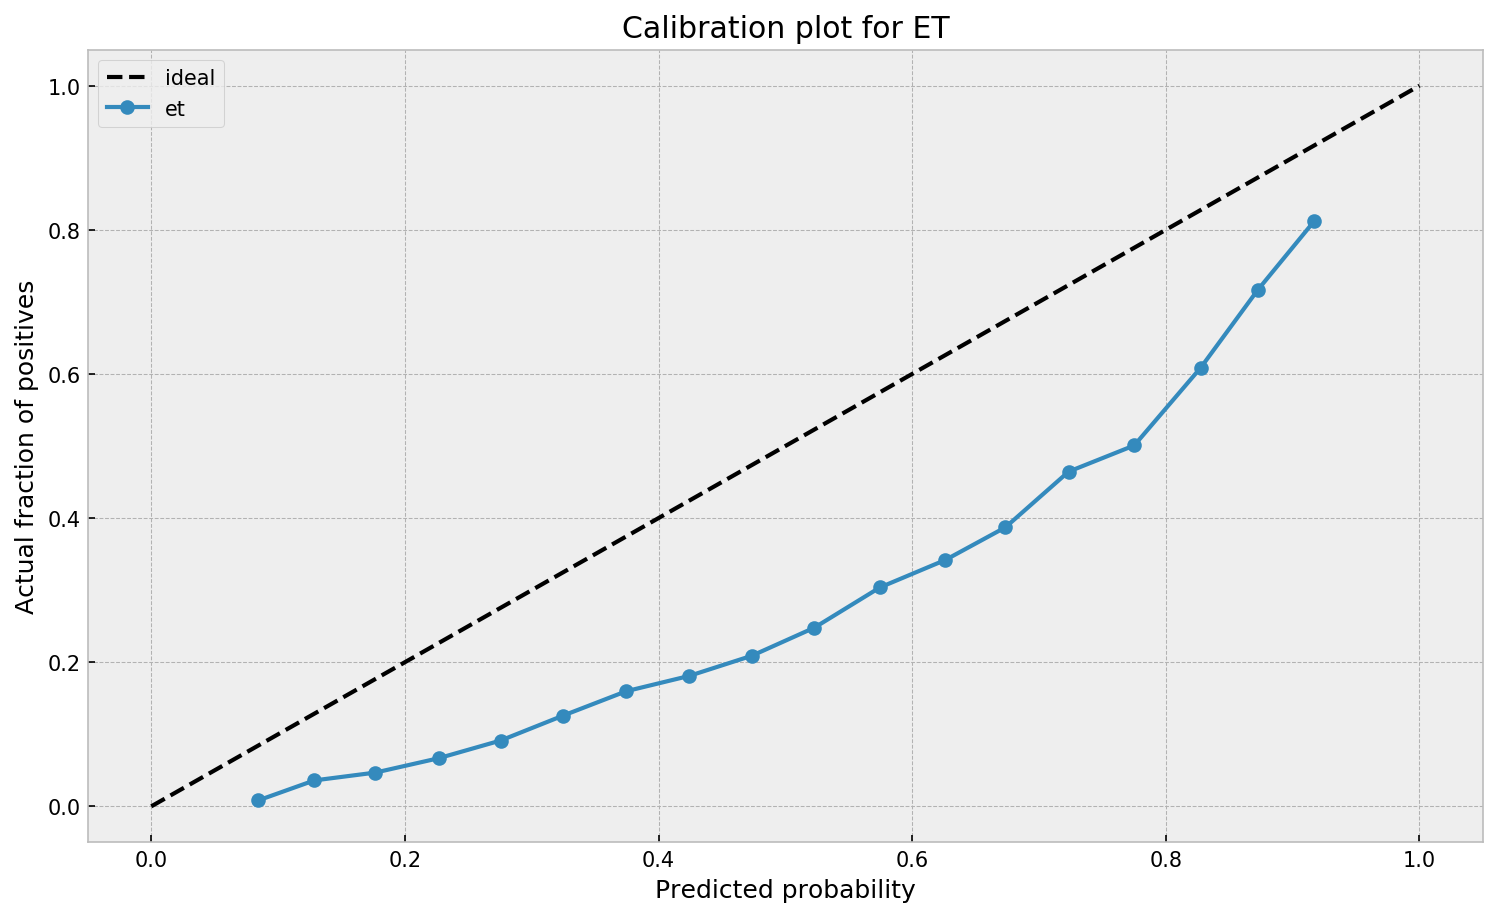

In [22]:
# opening figure
plt.figure(figsize=(12,7), dpi=150)

# plotting ideal line
plt.plot([0,1],[0,1], 'k--', label='ideal')

# plotting calibration for et
calibration_y = prob_df_et.groupby('prob_bin_val')['y'].mean()
calibration_x = prob_df_et.groupby('prob_bin_val')['y_hat'].mean()
plt.plot(calibration_x, calibration_y, marker='o', label='et')

# legend and titles
plt.title('Calibration plot for ET')
plt.xlabel('Predicted probability')
plt.ylabel('Actual fraction of positives')
plt.legend()
plt.show()

We can see that `ETC` overestimates the true probability across the board, despite having a wider probability range in comparison to GBM. Both models need a correction on their output probabilities. So how can we do that?  

## Logistic Regression on the leaves of forests

Let us show how to use a logistic regression on the leaves of forests in order to improve probability calibration. We first fit a tree-based model on the data:

In [19]:
# first, we fit our tree-based model on the dataset
lgbm.fit(X, y)

LGBMClassifier(boosting_type='gbdt', class_weight=None,
        colsample_bytree=0.603966803045847,
        learning_rate=0.0020772719973171654, max_depth=-1,
        min_child_samples=27, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=229, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=0.5352700870329835, subsample_for_bin=200000,
        subsample_freq=1)

Then, we use the `.apply` method to get the indices of the leaves each sample ended up into.

In [20]:
# then, we apply the model to the data in order to get the leave indexes
leaves = lgbm.apply(X)
leaves

array([[ 11,  44,  50, ...,   1,   1,  27],
       [140,  69,  70, ...,  17, 125,  41],
       [149,  10, 219, ...,  90, 190, 154],
       ...,
       [164,  35, 205, ...,  56,  55, 168],
       [168,  50,  11, ..., 112, 188, 100],
       [119, 193, 216, ..., 197, 146, 201]])

We're not yet ready to fit the logistic model on this matrix. So, we apply one-hot encoding to have dummies indicating leaf assignments:

In [21]:
# then, we one-hot encode the leave indexes so we can use them in the logistic regression
encoder = OneHotEncoder()
leaves_encoded = encoder.fit_transform(leaves)
leaves_encoded

<30000x22900 sparse matrix of type '<class 'numpy.float64'>'
	with 3000000 stored elements in Compressed Sparse Row format>

Now, we're ready to fit the model. The `leaves_encoded` variable contains a very powerful feature transformation of the data, learned by the GBM model. For more info about this kind of transformation, refer to the [Facebook paper](http://quinonero.net/Publications/predicting-clicks-facebook.pdf) I cited in the beginning of the post. 

We configure the logistic regression so it has strong regularization (as the leaf encoding is high-dimensional) and no intercept. We also use `sag` solver to speed things up.

In [22]:
# we configure the logistic regression and fit it to the encoded leaves
lr = LogisticRegression(solver='sag', C=10**(-3), fit_intercept=False)
lr.fit(leaves_encoded, y)

LogisticRegression(C=0.001, class_weight=None, dual=False,
          fit_intercept=False, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='sag', tol=0.0001, verbose=0, warm_start=False)

We can now compare the probabilities before and after the application of the logistic regression model. As it tries to minimize log-loss, we expect that its output probabilities are better calibrated. The scatterplot below show the differences in probability calibration:

In [23]:
# let us check probabilities before and after logistic regression
preds_lgbmlr = lr.predict_proba(leaves_encoded)
preds_lgbm = lgbm.predict_proba(X)

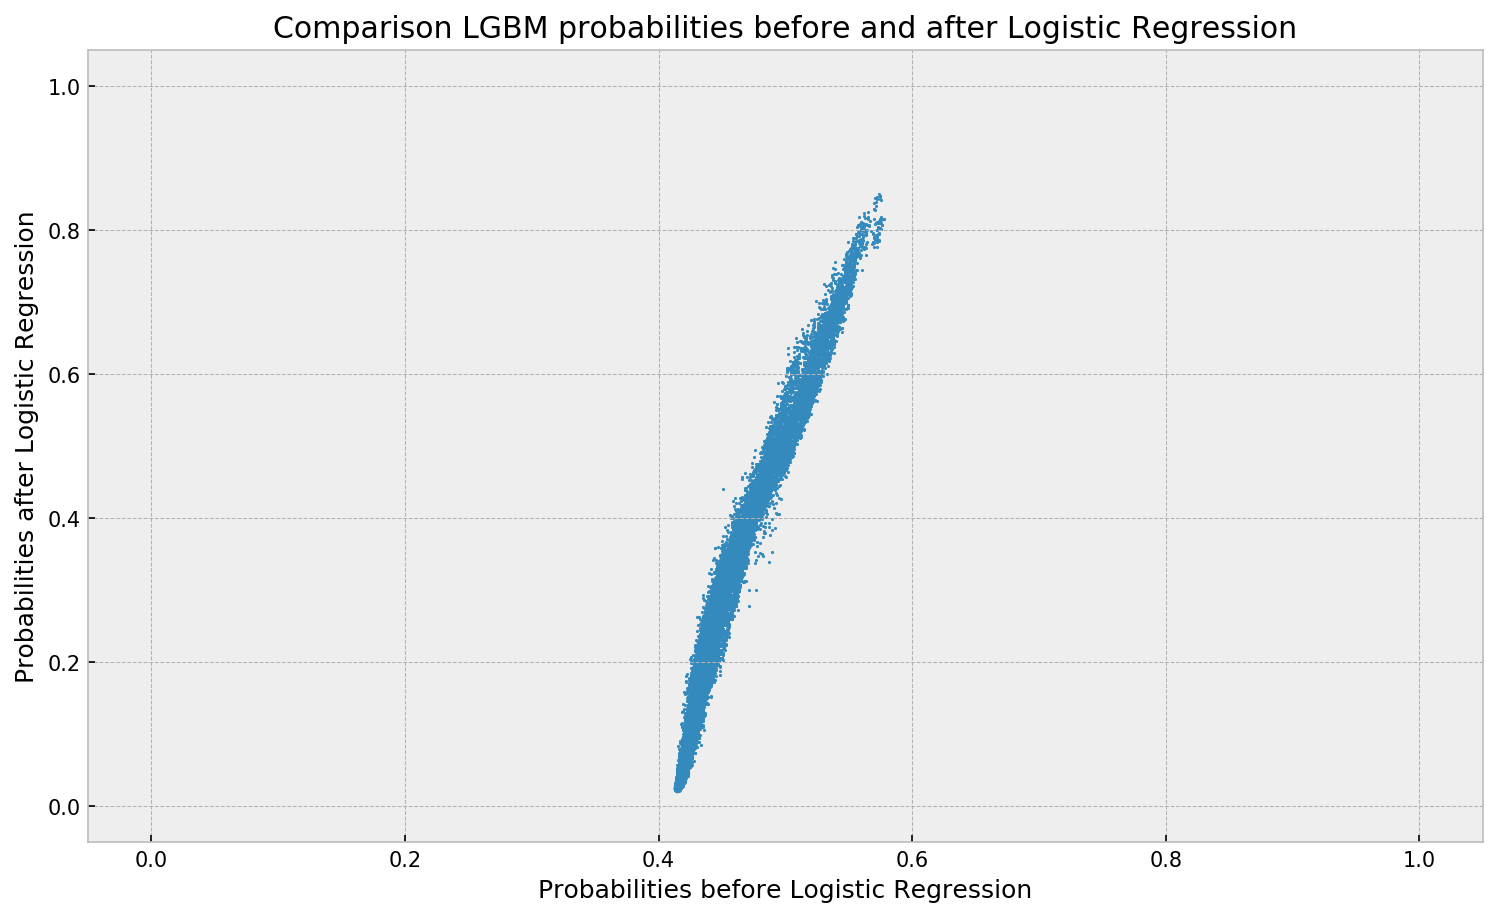

In [24]:
# plotting the probabilities
plt.figure(figsize=(12,7), dpi=150)
plt.scatter(preds_lgbm[:,1], preds_lgbmlr[:,1], s=1)
plt.xlim(-0.05,1.05); plt.ylim(-0.05,1.05)

# adding text
plt.title('Comparison LGBM probabilities before and after Logistic Regression')
plt.xlabel('Probabilities before Logistic Regression')
plt.ylabel('Probabilities after Logistic Regression');

We can see the the range of the output probabilities is wider after logistic regression. Also, the mapping resembles the calibration plot of LGBM, so LR may be actually correcting it.

However, we're just analyzing training data. Let us build a robust pipeline so we can see the calibration plots in validation before taking any conclusions. The following class does just that:

In [25]:
# class for the tree-based/logistic regression pipeline
class TreeBasedLR:
    
    # initialization
    def __init__(self, forest_params, lr_params, forest_model):
        
        # storing parameters
        self.forest_params = forest_params
        self.lr_params = lr_params 
        self.forest_model = forest_model
        
    # method for fitting the model
    def fit(self, X, y, sample_weight=None):
        
        # dict for finding the models
        forest_model_dict = {'et': ExtraTreesClassifier, 'lgbm': LGBMClassifier}
        
        # configuring the models
        self.lr = LogisticRegression(**self.lr_params)
        self.forest = forest_model_dict[self.forest_model](**self.forest_params)
        self.classes_ = np.unique(y)
        
        # first, we fit our tree-based model on the dataset
        self.forest.fit(X, y)
        
        # then, we apply the model to the data in order to get the leave indexes
        leaves = self.forest.apply(X)
        
        # then, we one-hot encode the leave indexes so we can use them in the logistic regression
        self.encoder = OneHotEncoder()
        leaves_encoded = self.encoder.fit_transform(leaves)
        
        # and fit it to the encoded leaves
        self.lr.fit(leaves_encoded, y)
        
    # method for predicting probabilities
    def predict_proba(self, X):
        
        # then, we apply the model to the data in order to get the leave indexes
        leaves = self.forest.apply(X)
        
        # then, we one-hot encode the leave indexes so we can use them in the logistic regression
        leaves_encoded = self.encoder.transform(leaves)
        
        # and fit it to the encoded leaves
        y_hat = self.lr.predict_proba(leaves_encoded)
        
        # retuning probabilities
        return y_hat
    
    # get_params, needed for sklearn estimators
    def get_params(self, deep=True):
        return {'forest_params': self.forest_params,
                'lr_params': self.lr_params,
                'forest_model': self.forest_model}

We also change the seed of the validation so that the next model selections are fair.

In [26]:
# validation process
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=102)

### Fixing LGBM probabilities

Let us calibrate the probabilities of our vanilla LGBM Model. The following code configures via random search the regularization paramter `C` of the logistic regression. As stated earlier, we use a different random seed in the validation to avoid overfitting.

In [27]:
# dataframe with experiment results
results_df_lr = pd.DataFrame()
results_df_tree = pd.DataFrame()

# random search of parameters
N_TRIALS = 20
for trial_id in range(N_TRIALS):
    
    # choosing parameters for tree-based
    tree_params = best_params_lgbm
    
    # choosing parameters for LR
    lr_params = {'solver':'sag',
                 'C': 10**np.random.uniform(-4,-2),
                 'fit_intercept': False}
    
    # printing the parameters
    print(lr_params)
    
    # configuring the model
    tblr = TreeBasedLR(tree_params, lr_params, forest_model='lgbm')
    
    # running CV
    preds = cross_val_predict(tblr, X, y, cv=skf, method='predict_proba')
    
    # evaluating
    result = roc_auc_score(y, preds[:,1])
    print(result)
    print('')
    
    # saving to lr params df
    temp_results = pd.concat([pd.DataFrame(lr_params, index=[trial_id]), pd.DataFrame({'result':result}, index=[trial_id])], axis=1)
    results_df_lr = pd.concat([results_df_lr, temp_results])

{'solver': 'sag', 'C': 0.0008500931520572406, 'fit_intercept': False}
0.7830792349739464

{'solver': 'sag', 'C': 0.0002699695848494383, 'fit_intercept': False}
0.7796624197812247

{'solver': 'sag', 'C': 0.0017677405128236584, 'fit_intercept': False}
0.7828789234536392

{'solver': 'sag', 'C': 0.00010098236150968717, 'fit_intercept': False}
0.775435870567012

{'solver': 'sag', 'C': 0.004387030540868053, 'fit_intercept': False}
0.7786922598188958

{'solver': 'sag', 'C': 0.00044798333568780963, 'fit_intercept': False}
0.781596096409173

{'solver': 'sag', 'C': 0.0001761447920140676, 'fit_intercept': False}
0.7778239744891214

{'solver': 'sag', 'C': 0.003679556425464747, 'fit_intercept': False}
0.779914974702842

{'solver': 'sag', 'C': 0.0005844629009332102, 'fit_intercept': False}
0.7823720076656678

{'solver': 'sag', 'C': 0.0002787967109864126, 'fit_intercept': False}
0.779799162046802

{'solver': 'sag', 'C': 0.0004217204559400536, 'fit_intercept': False}
0.7813922052484057

{'solver': 'sa

We maintain original GBM results, with AUC = 0.78. Let us now check the calibration of this model:

In [28]:
# checking the results
results_df_lr.sort_values('result', ascending=False).head(5)

,C,fit_intercept,solver,result
18,0.001354,False,sag,0.783226
0,0.000850,False,sag,0.783079
17,0.001703,False,sag,0.782945
2,0.001768,False,sag,0.782879
14,0.001915,False,sag,0.782701


In [29]:
# choosing parameters for tree-based
tree_params = best_params_lgbm

# choosing parameters for LR
lr_params = (results_df_lr
             .sort_values('result', ascending=False)
             .iloc[0]
             .drop('result')
             .to_dict())

# configuring the model
tblr = TreeBasedLR(tree_params, lr_params, forest_model='lgbm')

# running CV
preds = cross_val_predict(tblr, X, y, cv=skf, method='predict_proba')

In [30]:
# creating a dataframe of target and probabilities
prob_df_lgbm_lr = pd.DataFrame({'y':y, 'y_hat': preds[:,1]})

In [31]:
# binning the dataframe, so we can see success rates for bins of probability
bins = np.arange(0.05, 1.00, 0.05)
prob_df_lgbm_lr.loc[:,'prob_bin'] = np.digitize(prob_df_lgbm_lr['y_hat'], bins)
prob_df_lgbm_lr.loc[:,'prob_bin_val'] = prob_df_lgbm_lr['prob_bin'].replace(dict(zip(range(len(bins) + 1), list(bins) + [1.00])))

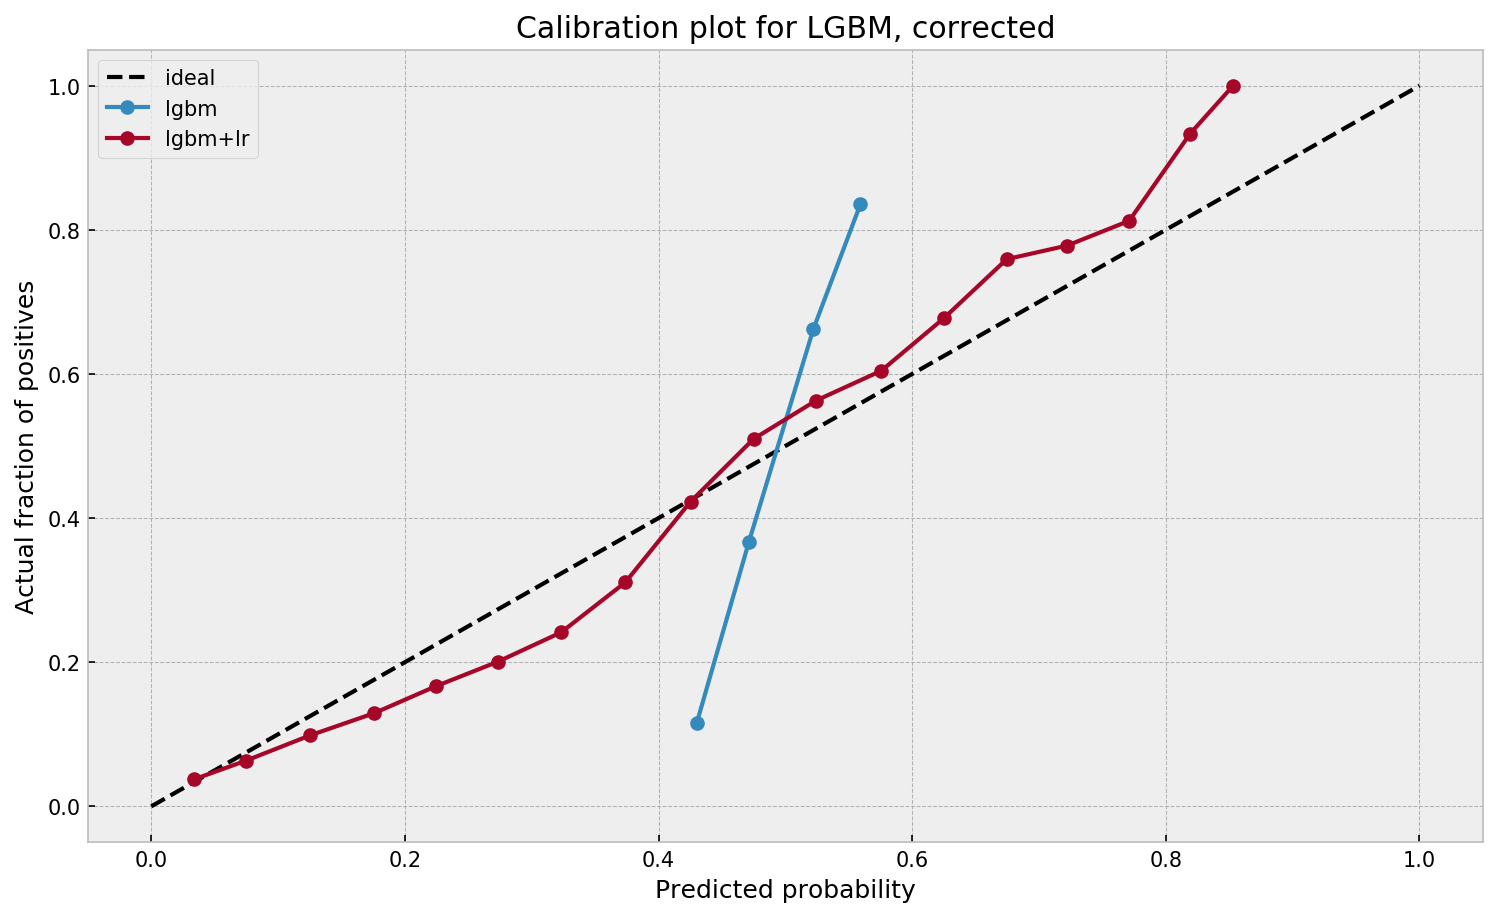

In [32]:
# opening figure
plt.figure(figsize=(12,7), dpi=150)

# plotting ideal line
plt.plot([0,1],[0,1], 'k--', label='ideal')

# plotting calibration for lgbm
calibration_y = prob_df_lgbm.groupby('prob_bin_val')['y'].mean()
calibration_x = prob_df_lgbm.groupby('prob_bin_val')['y_hat'].mean()
plt.plot(calibration_x, calibration_y, marker='o', label='lgbm')

# plotting calibration for lgbm+lr
calibration_y = prob_df_lgbm_lr.groupby('prob_bin_val')['y'].mean()
calibration_x = prob_df_lgbm_lr.groupby('prob_bin_val')['y_hat'].mean()
plt.plot(calibration_x, calibration_y, marker='o', label='lgbm+lr')

# legend and titles
plt.title('Calibration plot for LGBM, corrected')
plt.xlabel('Predicted probability')
plt.ylabel('Actual fraction of positives')
plt.legend()

Much better. The calibration plot of `lgbm+lr` is much closer to the ideal. Now, when the model tells us that the probability of success is 60%, we can actually be much more confident that this is the true fraction of success! Let us now try this with the ET model.

### Fixing ET probabilities

Same drill for our `ExtraTreesClassifier`:

In [33]:
# dataframe with experiment results
results_df_lr = pd.DataFrame()
results_df_tree = pd.DataFrame()

# random search of parameters
N_TRIALS = 20
for trial_id in range(N_TRIALS):
    
    # choosing parameters for tree-based
    tree_params = best_params_et
    
    # choosing parameters for LR
    lr_params = {'solver':'sag',
                 'C': 10**np.random.uniform(-4,-2),
                 'fit_intercept': False}
    
    # printing the parameters
    print(lr_params)
    
    # configuring the model
    tblr = TreeBasedLR(tree_params, lr_params, forest_model='et')
    
    # running CV
    preds = cross_val_predict(tblr, X, y, cv=skf, method='predict_proba')
    
    # evaluating
    result = roc_auc_score(y, preds[:,1])
    print(result)
    print('')
    
    # saving to lr params df
    temp_results = pd.concat([pd.DataFrame(lr_params, index=[trial_id]), pd.DataFrame({'result':result}, index=[trial_id])], axis=1)
    results_df_lr = pd.concat([results_df_lr, temp_results])

{'solver': 'sag', 'C': 0.0023648610348284598, 'fit_intercept': False}
0.7832984508657648

{'solver': 'sag', 'C': 0.0017560758833879645, 'fit_intercept': False}
0.7837811734440677

{'solver': 'sag', 'C': 0.007155479584720549, 'fit_intercept': False}
0.7781196108674118

{'solver': 'sag', 'C': 0.009501921752764429, 'fit_intercept': False}
0.7774176627225865

{'solver': 'sag', 'C': 0.00018467930973566017, 'fit_intercept': False}
0.7801452584559749

{'solver': 'sag', 'C': 0.007020182119418029, 'fit_intercept': False}
0.778168716439742

{'solver': 'sag', 'C': 0.004336090032791866, 'fit_intercept': False}
0.7810493885638705

{'solver': 'sag', 'C': 0.0032412856595549554, 'fit_intercept': False}
0.7815378546914162

{'solver': 'sag', 'C': 0.00018480390302017436, 'fit_intercept': False}
0.7805349265068209

{'solver': 'sag', 'C': 0.004388212543690571, 'fit_intercept': False}
0.7816593205994622

{'solver': 'sag', 'C': 0.0024011303329025293, 'fit_intercept': False}
0.7829384132082051

{'solver': 'sa

In [34]:
# checking the results
results_df_lr.sort_values('result', ascending=False).head(5)

,C,fit_intercept,solver,result
1,0.001756,False,sag,0.783781
11,0.001055,False,sag,0.783462
14,0.002032,False,sag,0.783449
0,0.002365,False,sag,0.783298
10,0.002401,False,sag,0.782938


No loss of AUC here as well, as the logistic model does a good job of learning from the forest's leaves. Let us check the calibration:

In [35]:
# choosing parameters for tree-based
tree_params = best_params_et

# choosing parameters for LR
lr_params = (results_df_lr
             .sort_values('result', ascending=False)
             .iloc[0]
             .drop('result')
             .to_dict())

# configuring the model
tblr = TreeBasedLR(tree_params, lr_params, forest_model='et')

# running CV
preds = cross_val_predict(tblr, X, y, cv=skf, method='predict_proba')

In [36]:
# creating a dataframe of target and probabilities
prob_df_et_lr = pd.DataFrame({'y':y, 'y_hat': preds[:,1]})

In [37]:
# binning the dataframe, so we can see success rates for bins of probability
bins = np.arange(0.05, 1.00, 0.05)
prob_df_et_lr.loc[:,'prob_bin'] = np.digitize(prob_df_et_lr['y_hat'], bins)
prob_df_et_lr.loc[:,'prob_bin_val'] = prob_df_et_lr['prob_bin'].replace(dict(zip(range(len(bins) + 1), list(bins) + [1.00])))

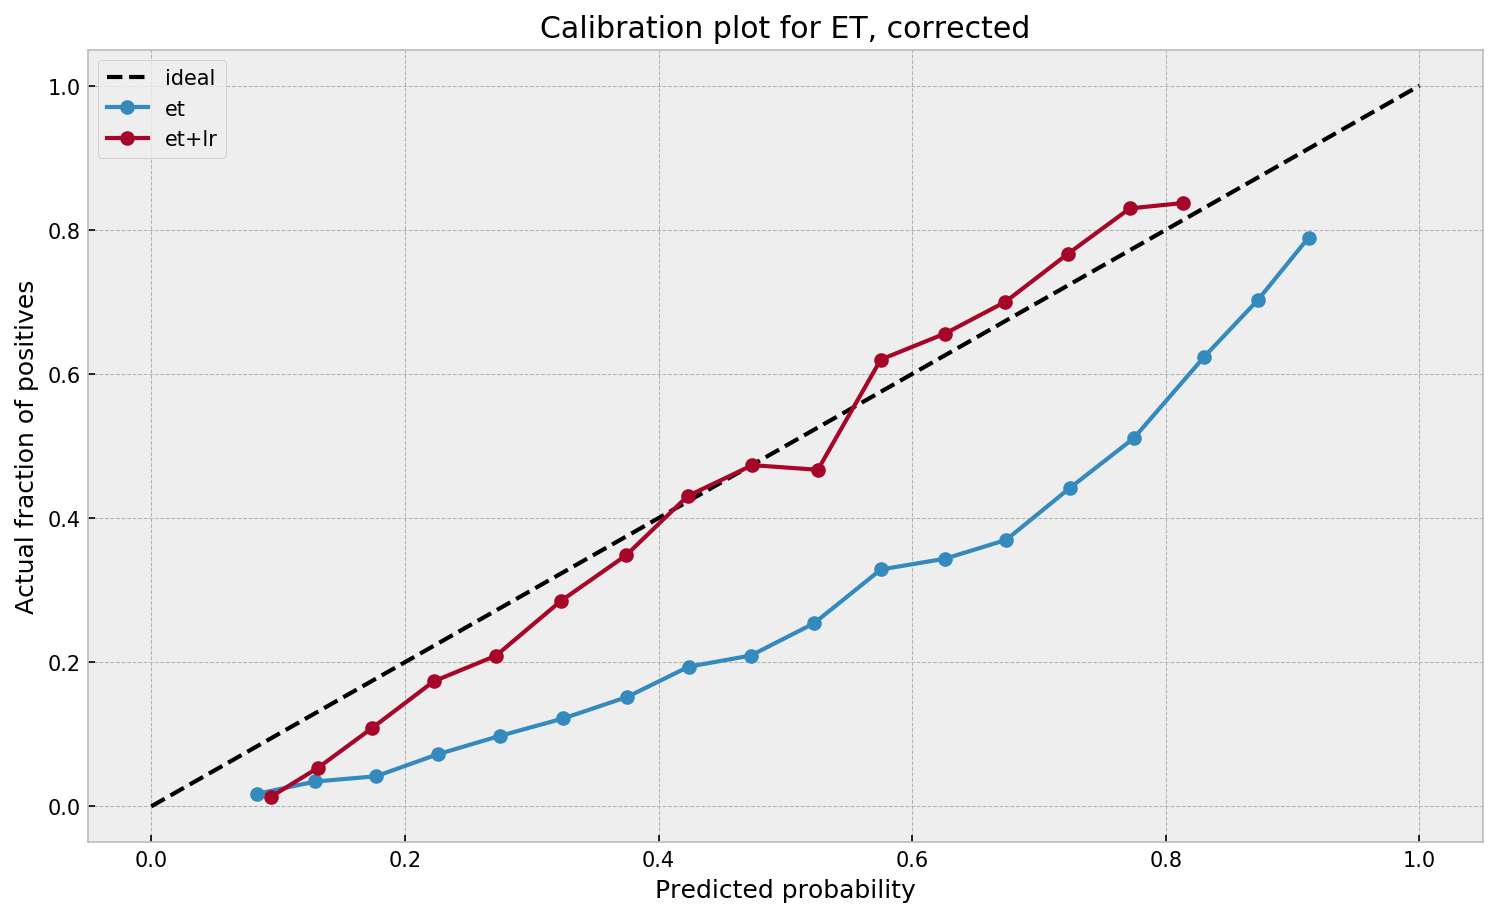

In [38]:
# opening figure
plt.figure(figsize=(12,7), dpi=150)

# plotting ideal line
plt.plot([0,1],[0,1], 'k--', label='ideal')

# plotting calibration for et
calibration_y = prob_df_et.groupby('prob_bin_val')['y'].mean()
calibration_x = prob_df_et.groupby('prob_bin_val')['y_hat'].mean()
plt.plot(calibration_x, calibration_y, marker='o', label='et')

# plotting calibration for lgbm+lr
calibration_y = prob_df_et_lr.groupby('prob_bin_val')['y'].mean()
calibration_x = prob_df_et_lr.groupby('prob_bin_val')['y_hat'].mean()
plt.plot(calibration_x, calibration_y, marker='o', label='et+lr')

# legend and titles
plt.title('Calibration plot for ET, corrected')
plt.xlabel('Predicted probability')
plt.ylabel('Actual fraction of positives')
plt.legend()

Not as good as the GBM correction, but calibration improved significantly. 

## Conclusion

In this post, we showed a strategy to calibrate output probabilities of a tree-based model by fitting a logistic regression on its one-hot encoded leaf assigments. The strategy greatly improves calibration while not losing predictive power. Thus, we can now be much more confident that the output probabilities of our models actually correspond to true fractions of success.

As always, you can find the complete code at my [GitHub]().